# 探索的データ分析の結果から得た下記の仮説を検証する
- ## Parch,SibSp共に一定の値を超えると生存率が下がる
## →仮説：「Parch,SibSpを足し合わせた『家族の人数』という新しい特徴量を作ると、予測性能に寄与する可能性がある」

# 以前のコード
<span style="color: red; ">再現性を担保するため若干の改良：年齢をランダム値で補完→中央値で補完</span>

In [69]:
# パッケージのimport
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# データの読み込み
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

data = pd.concat([train, test], sort=False)

# 特徴量エンジニアリング
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
# 年齢：欠損値を中央値で補間
data['Age'].fillna(data['Age'].median(), inplace=True)

# 学習に使用しないカラムを除去
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)

# 学習データとテストデータに分割
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

# ロジスティック回帰で機械学習
clf = LogisticRegression(penalty='l2', solver='sag', random_state=0)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# 仮説から新しい特徴量を作る

以前のコードと同じ部分

In [70]:
# データの読み込み
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

data = pd.concat([train, test], sort=False)

# 特徴量エンジニアリング
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
# 年齢：欠損値を中央値で補間
data['Age'].fillna(data['Age'].median(), inplace=True)

## <span style="color: red; ">家族の人数（FamiliySize）という列を作り可視化する</span>
- <span style="color: red; ">「FamilySize>=5の場合、生存率が低いので、この特徴量は予測性能に寄与しそうだ」という確度の高い仮説に変わった</span>

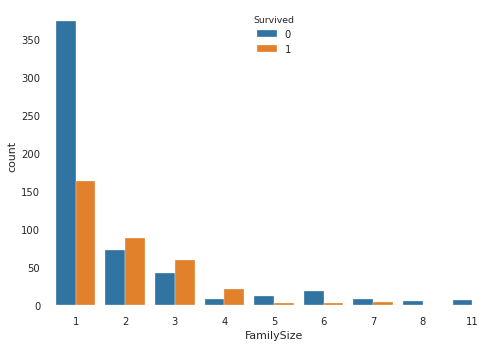

In [71]:
import seaborn as sns
data["FamilySize"] = data["Parch"] + data["SibSp"] + 1
train["FamilySize"] = data["FamilySize"][:len(train)]
test["FamilySize"] = data["FamilySize"][len(train):]
sns.countplot(x="FamilySize", data=train, hue="Survived")

- <span style="color: red; ">FamilySize==1の時は特に生存率が低いということもわかる　→　IsAloneという特徴量も作成する</span>

In [72]:
data["IsAlone"] = 0
data.loc[data["FamilySize"] == 1, "IsAlone"] = 1
train["IsAlone"] = data["IsAlone"][:len(train)]
test["IsAlone"] = data["IsAlone"][len(train):]

In [73]:
# 学習に使用しないカラムを除去
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)

# 学習に使用しないカラムを除去
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,3,0,22.0,7.2500,0,2,0
1,1,1,38.0,71.2833,1,2,0
2,3,1,26.0,7.9250,0,1,1
3,1,1,35.0,53.1000,0,2,0
4,3,0,35.0,8.0500,0,1,1


# 予測性能の比較

In [74]:
sub = pd.read_csv('../input/titanic/gender_submission.csv')

- FamilySizeとIsAloneの両方を予測に用いた場合

In [75]:
# 機械学習
clf.fit(X_train, y_train)
y_pred_familysize_isalone = clf.predict(X_test)

# 提出用ファイル作成
sub['Survived'] = list(map(int, y_pred_familysize_isalone))
sub.to_csv('submission_familysize_isalone.csv', index=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


- IsAloneのみ予測に用いた場合

In [76]:
clf.fit(X_train.drop('FamilySize', axis=1), y_train)
y_pred_isalone = clf.predict(X_test.drop('FamilySize', axis=1))

sub['Survived'] = list(map(int, y_pred_isalone))
sub.to_csv('submission_isalone.csv', index=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


- FamiliySizeのみ予測に用いた場合

In [77]:
clf.fit(X_train.drop('IsAlone', axis=1), y_train)
y_pred_familysize = clf.predict(X_test.drop('IsAlone', axis=1))

sub['Survived'] = list(map(int, y_pred_familysize))
sub.to_csv('submission_familysize.csv', index=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


- 以前のコードのままの場合

In [78]:
clf.fit(X_train.drop(['FamilySize', 'IsAlone'], axis=1), y_train)
y_pred = clf.predict(X_test.drop(['FamilySize', 'IsAlone'], axis=1))

sub['Survived'] = list(map(int, y_pred))
sub.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# 結果
## 家族が乗船しているかどうかはあまり関係ないことがわかった
- 以前のコードのままの場合:0.66507
- FamiliySizeを追加した場合:0.65550
- IsAloneを追加した場合：0.66507
- FamiliySizeとIsAloneを追加した場合：0.65550